In [1]:
import h5py
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms
import torch 
# from torchmetrics.functional import structural_similarity_index_measure as ssim
import torchvision.transforms.functional as trans_F
from torch import nn, optim, functional as F
import pytorch_lightning as pl
import os
import matplotlib.pyplot as plt
import multiprocessing as mp
import torchvision
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/"

The given jupyter notebook contains code for task 1 evaluation of Genie Project <br>
Task objectives : <br>
<ul>
    <li>Train an Auto-Encoder to learn a representation based on three images channels <br>
        i.e. :<br>
        <ul>
                <li> ECAL -> Electromagnetic Calorimeter<br>
                <li> HCAL -> Hadronic Calorimeter<br>
                <li> Tracks<br>
        </ul>
    <li> Show a side-by-side comparison of original and reconstructed events<br>
</ul><br>
<hr>
<br>
The Quark-Gluon hdfs dataset was in compressed format so when loading every element batch wise it was decompressing it, <br>
and then reading it which was taking up unnecessary time so, an uncompressed version with the same chunk_size of (6000,...) <br>
events per-chunk was created.

In [2]:
def decompress_dataset(raw_path,  processed_path):
    with h5py.File(raw_path, 'r') as r, h5py.File(processed_path, 'w') as p:
        keys = list(r.keys())
        total_events = r[keys[0]].shape[0]
        for key in keys:
            if len(r[key].shape) > 1:
                chunk_shape = tuple([6000] + list(r[key].shape[1:]))
            else:
                chunk_shape = (6000,)
            p.create_dataset(key, shape=r[key].shape, chunks= chunk_shape)
            for i in tqdm(range(0, total_events, 6000)): #iterate till we reach the last element in the dataset for that feature
                stop_idx = min(i+6000, total_events)
                p[key][i:stop_idx] = r[key][i:stop_idx]

In [3]:
raw_path = "../Data/hdf5/raw/quark-gluon_data-set_n139306.hdf5"
uncompressed_data_path = "../Data/hdf5/processed/quark-gluon-dataset.hdf5"
subset_data_path = "../Data/hdf5/processed/processed.hdf5"

In [4]:
def subset_dataset(raw_path, processed_path, subset_len = 6000):
    with h5py.File(raw_path, 'r') as f, h5py.File(processed_path, 'w') as p:
        keys = list(f.keys())
        total_events = f[keys[1]].shape[0]
        for key in keys:
            shape = (subset_len,)
            if len(f[key].shape) > 1:
                shape = (subset_len, 125, 125, 3)
            p.create_dataset(key, shape=shape)
        quark_count = 0
        gluon_count = 0
        idx = 0
        for i in range(total_events):
            if quark_count < subset_len // 2:
                for key in keys:
                    p[key][idx] = f[key][idx]
                quark_count += 1
                idx += 1
            elif gluon_count < subset_len // 2:
                for key in keys:
                    p[key][idx] = f[key][idx]
                gluon_count += 1
                idx += 1
            elif idx >= subset_len:
                break
            

In [5]:
if not os.path.exists(uncompressed_data_path):
    decompress_dataset(raw_path, uncompressed_data_path)
if not os.path.exists(subset_data_path):
    subset_dataset(uncompressed_data_path, subset_data_path)

### Quark-Gluon Torch Dataset Class

In [6]:
class QuarkGluonDataset(Dataset):
    def __init__(self, path, channel = 0, transform = None) -> None:
        super().__init__()
        self.path = path
        self.channel = channel
        self.transform = transform
        with h5py.File(self.path, 'r') as f:
            self.keys = list(f.keys())
    def __len__(self):
        with h5py.File(self.path, 'r') as f:
            return len(f[self.keys[1]])
    def __getitem__(self, index):
        with h5py.File(self.path, 'r') as f:
            x = f[self.keys[0]][index]
            x = torch.from_numpy(x)
            x = torch.permute(x, (2, 0, 1)) # convert (n, n, 3) -> (3, n, n)
            if self.transform is not None:
                x = self.transform(x)
                return x
            return x
        

### Methodology
<ol>
    <li>Divide pytorch Quark dataset into:
        <ul>
        <li> Train -> 60%
        <li> Validation -> 20%
        <li> Test -> 20%
        </ul>
    <li> Create pytorch lightning DataModule with following with train, val and test dataloaders
</ol>

### Bottle-Necks:
<ol>
    <li>Dataset is too large
    <li> Not enough GPU VRAM to try out larger and more state of the art models
</ol>

### Adopted Solutions
<ol>
    <l1> Use only a subset of the dataset about 6K events
    <li> Use a lighter model for proof of concept
</ol>

In [7]:

def train_val_test_split(dataset, train = 0.6, val = 0.2, test = 0.2):
    train_data, val_data, test_data = random_split(dataset, [train, val, test])
    datasets = {}
    datasets['train'] = train_data
    datasets['val'] = val_data
    datasets['test'] = test_data
    return datasets

cpu_count = mp.cpu_count()

transform = transforms.Compose([
                transforms.Normalize(mean=0.5, std=1),
                ])
dataset = QuarkGluonDataset(subset_data_path, transform = transform)
dataset =  train_val_test_split(dataset)
train_data = dataset['train']
val_data = dataset['val']
test_data = dataset['test']

class QuarkGluonDataModule(pl.LightningDataModule):
    def __init__(self,dataset, batch_size = 64) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataset = dataset
    def setup(self, stage:str):
        self.train_data = self.dataset['train']
        self.val_data = self.dataset['val']
        self.test_data = self.dataset['test']
    def get_train(self, idx):
        return self.train_data[idx][0]
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=cpu_count, prefetch_factor=2* cpu_count)
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, num_workers=cpu_count, prefetch_factor=2* cpu_count)
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False, num_workers=cpu_count, prefetch_factor=2* cpu_count)
    

### NN layer to print the dimesions of input data

In [8]:
class PrintDim(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    def forward(self, x):
        print(x.shape)
        print("-" * 50)
        return x
    

### Encoder layer
Architecture :
<ul>
<li> CNN layer
<li> Activation Funtion -> Relu
<li> pooling layers -> maxpool, adaptive avg pooling
<li> Normalization -> BatchNorm
</ul>

In [9]:
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For QuarkGluon, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 125x125 => 63x63
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 63x63 => 32x32
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*16*c_hid, latent_dim) # input_dim => 32768 ~ 2x16x16x c_hid 
        )

    def forward(self, x):
        return self.net(x)

### Decoder Layer 
Architecture :
<ul>
<li> ConvTranspose2d layer
<li> Normalization -> BatchNorm
</ul>

In [11]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For QUarkGluon, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=0, padding=1, stride=2), # 32x32 => 63x63
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=0, padding=1, stride=2), # 63x63 => 125x125
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 16, 16)
        x = self.net(x)
        return x

### Encoder Decoder layer stacked to make CNN AutoEncoder
<ul>
<li> Loss function -> structural similarity index measure
<li> Optimiser -> AdaGrad
</ul>

In [13]:
class ConvAutoEncoder(pl.LightningModule):
    def __init__(self,
                base_channel_size: int,
                latent_dim: int,
                encoder_class : object = Encoder,
                decoder_class : object = Decoder,
                num_input_channels: int = 3,
                width: int = 125,
                height: int = 125,
                lr: float = 1e-3):
        super().__init__()
        self.lr = lr
        self.save_hyperparameters()

        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def _get_reconstruction_loss(self, batch):
        reconstructed = self.decoder(self.encoder(batch))
        loss = torch.nn.functional.mse_loss(batch, reconstructed, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss
    def configure_optimizers(self):
        optimiser = optim.Adam(self.parameters(), lr = self.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimiser,
                                                         mode='min',
                                                         factor=.2,
                                                         patience=20,
                                                         min_lr = 5e-5,
                                                         )
        return {
                "optimizer": optimiser,
                "lr_scheduler":scheduler,
                "monitor":"val_loss"
                }
    def training_step(self, batch, batc_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss.item())
        return loss
    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss.item())
        return loss
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss.item())
        return loss
    

In [14]:
class GenerateCallback(pl.Callback):

    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step) # results of reconstruction of events after 
                                                                                                          #  2 epochs is logged and can be viewd using tensorboard

In [15]:
transform = transforms.Compose([
    transforms.Normalize(mean=0.5, std=1),
    ])
data_module = QuarkGluonDataModule(dataset, batch_size=64) #increasing the batch size may cause GPU memory overflow

In [16]:
def get_train_images(num):
    return torch.stack([dataset['train'][i] for i in range(num)])


In [17]:


def train_QuarkGluon(latent_dim,epochs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"QuarkGluon_{latent_dim}"),
                         accelerator="gpu",
                         devices="auto",
                         max_epochs=epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=2),
                                    LearningRateMonitor("epoch")],
                        enable_progress_bar=False)
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need


    model = ConvAutoEncoder(base_channel_size=64, latent_dim=latent_dim)
    trainer.fit(model, datamodule=data_module)
    # Test best model on validation and test set
    val_result = trainer.test(model, datamodule=data_module, verbose=False)
    test_result = trainer.test(model, datamodule=data_module, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

In [18]:
model_dict = {}
for latent_dim in [64, 128, 256, 384]:
    model_ld, result_ld = train_QuarkGluon(latent_dim, 1000)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: saved_models/QuarkGluon_64/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0 | encoder | Encoder | 2.5 M  | [2, 3, 125, 125] | [2, 64]         
1 | decoder | Decoder | 2.5 M  | [2, 64]          | [2, 3, 125, 125]
--------------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
20.170    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU a

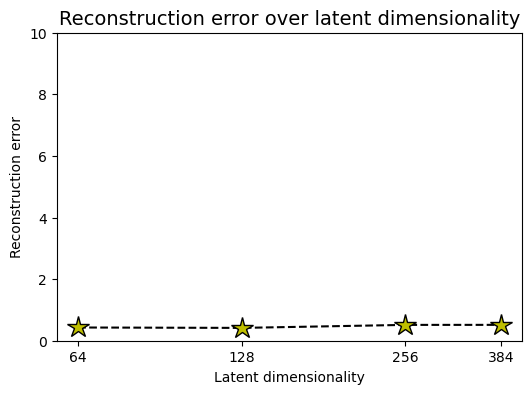

In [20]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"]["val"][0]["test_loss"] for k in latent_dims]

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0,10)
plt.show()


In [29]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

    return reconst_imgs


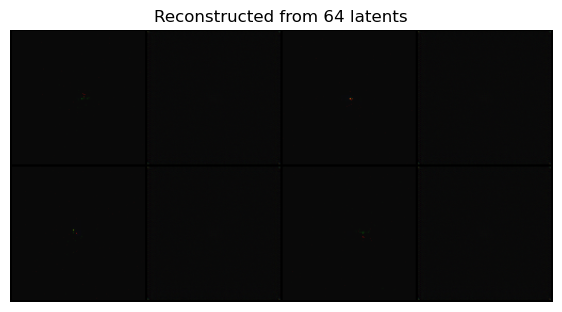

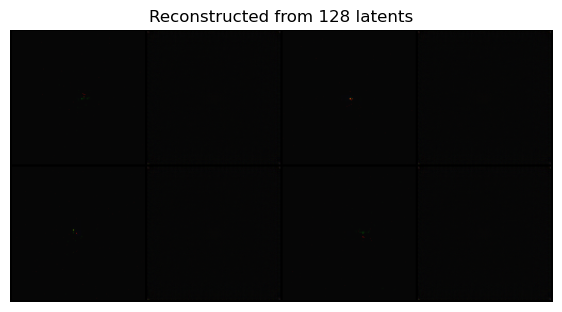

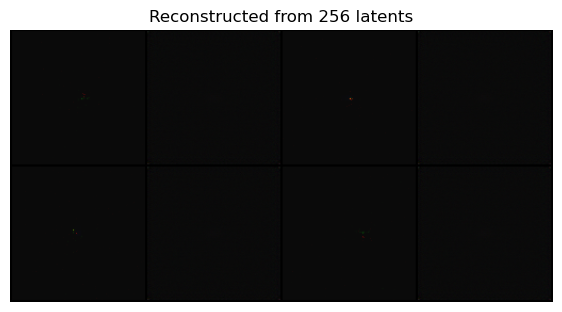

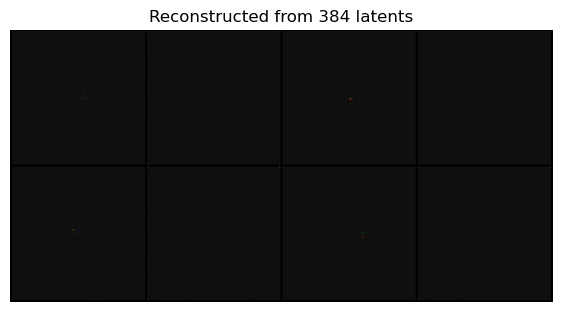

In [30]:
input_images = get_train_images(4)
for latent_dim in model_dict:
    recon_images = visualize_reconstructions(model_dict[latent_dim]["model"], input_images)

## Problems with the given approach
<ol>
    <li> The sparcity of the data is extremely high i.e. these events tend to have a very small <br>
    that are none-zero so even-though the loss is low we are not able to effectively recreate the <br>
    the original events. <br>
    Possible solution:
    <ul>
        <li> Rather than using a full 125*125 image of an event we should create a possible smaller snapshot <br>
        of the image to decrease the sparsity.
        <li> Increase the number of hidden layers and experiment with changing pooling layers and different <br>
        activation functions.
        <li> Try different loss functions such as structural similarity index measure to effectively capture <br>
         the structural information of the event.
    </ul>
</ol>